# Importing data

In [196]:
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from datetime import datetime


account_df = pd.read_csv('data/account.csv',sep=';')
client_df = pd.read_csv('data/client.csv',sep=';')
disp_df = pd.read_csv('data/disp.csv',sep=';')
district_df = pd.read_csv('data/district.csv',sep=';')

testing = False

if testing:
    card_df = pd.read_csv('data/card_comp.csv', sep=';')
    loan_df = pd.read_csv('data/loan_comp.csv', sep=';')
    trans_df = pd.read_csv("data/trans_comp.csv",sep=";", low_memory=False)
else:
    card_df = pd.read_csv('data/card_dev.csv', sep=';')
    loan_df = pd.read_csv('data/loan_dev.csv', sep=';')
    trans_df = pd.read_csv("data/trans_dev.csv",sep=";", low_memory=False)

# Account Stats

In [197]:
account_df.rename(columns={'frequency':'account_frequency'}, inplace=True)
account_df.rename(columns={'date':'account_date'}, inplace=True)

account_df.loc[account_df['account_frequency'] == 'monthly issuance', 'account_frequency'] = 'monthly'
account_df.loc[account_df['account_frequency'] == 'weekly issuance', 'account_frequency'] = 'weekly'
account_df.loc[account_df['account_frequency'] == 'issuance after transaction', 'account_frequency'] = 'after-transaction'
account_df['account_date'] = pd.to_datetime(account_df['account_date'], format='%y%m%d')
print(account_df.head())
account_df.to_csv('refined/account.csv')

   account_id  district_id account_frequency account_date
0         576           55           monthly   1993-01-01
1        3818           74           monthly   1993-01-01
2         704           55           monthly   1993-01-01
3        2378           16           monthly   1993-01-01
4        2632           24           monthly   1993-01-02


# Client Processing


In [198]:
client_df.rename(columns={'district_id':'client_district_id'}, inplace=True)
client_df.rename(columns={'birth_number':'client_birth_number'}, inplace=True)


age = []
gender = []
birth = []
get_birth_date = lambda x : pd.to_datetime('19'+str(x)[0:2] + str(x)[2:4] + str(x)[4:6])
for x in client_df['client_birth_number']:
    month = int(str(x)[2:4])
    if month > 12:
        gender.append("Female")
        x -= 5000
    else:
        gender.append("Male")
    #1 woman, 0 man
    birth_date = get_birth_date(x)
    birth.append(birth_date)
    age.append((datetime.now() - birth_date).days // 365)

client_df['client_birth_number'] = birth
client_df['client_age'] = age
client_df['client_gender'] = gender




client_df.to_csv('refined/client.csv')

# Disposition Processing

In [199]:
disp_df = disp_df.loc[disp_df.type == "OWNER"]
disp_df.drop(columns=['type'], inplace=True)
disp_df.rename(columns={'type':'disp_type'}, inplace=True)
disp_df.to_csv('refined/disposition.csv')

# Transaction Processing

In [200]:
trans_df.rename(columns={'date' : 'trans_date'}, inplace=True)
trans_df.rename(columns={'type' : 'trans_type'}, inplace=True)
trans_df.rename(columns={'operation' : 'trans_operation'}, inplace=True)
trans_df.rename(columns={'amount' : 'trans_amount'}, inplace=True)
trans_df.rename(columns={'balance' : 'trans_balance'}, inplace=True)
trans_df.rename(columns={'k_symbol' : 'trans_k_symbol'}, inplace=True)
trans_df.rename(columns={'bank' : 'trans_bank'}, inplace=True)
trans_df.rename(columns={'account': 'trans_account'}, inplace=True)

trans_df['trans_date'] = pd.to_datetime(trans_df['trans_date'], format='%y%m%d')
trans_df['trans_operation'].fillna('interest credited', inplace=True)

#as colunas bank e account não são necessárias, trans_k_symbol têm muitos valores nulos
trans_df.drop(['trans_bank', 'trans_account', 'trans_k_symbol'], axis=1, inplace=True)

#withdrawal in cash para withdrawal
trans_df.loc[trans_df["trans_type"]=="withdrawal in cash","trans_type"] = "withdrawal" 
#se for withdrawal, o ammount é negativo
trans_df.loc[trans_df["trans_type"]=="withdrawal","trans_amount"] *= -1
print(trans_df.head())




   trans_id  account_id trans_date trans_type               trans_operation  \
0   1548749        5270 1993-01-13     credit                credit in cash   
1   1548750        5270 1993-01-14     credit  collection from another bank   
2   3393738       11265 1993-01-14     credit                credit in cash   
3   3122924       10364 1993-01-17     credit                credit in cash   
4   1121963        3834 1993-01-19     credit                credit in cash   

   trans_amount  trans_balance  
0         800.0          800.0  
1       44749.0        45549.0  
2        1000.0         1000.0  
3        1100.0         1100.0  
4         700.0          700.0  


# Loan Processing

In [201]:

loan_df.rename(columns={'date':'loan_date'}, inplace=True)
loan_df.rename(columns={'amount':'loan_amount'}, inplace=True)
loan_df.rename(columns={'duration':'loan_duration'}, inplace=True)
loan_df.rename(columns={'payments':'loan_payments'}, inplace=True)
loan_df.rename(columns={'status':'loan_status'}, inplace=True)

loan_df['loan_date'] = pd.to_datetime(loan_df['loan_date'], format='%y%m%d')

loan_df.to_csv('refined/loan.csv')

loan_df.head()

,loan_id,account_id,loan_date,loan_amount,loan_duration,loan_payments,loan_status
0,5314,1787,1993-07-05,96396,12,8033,-1
1,5316,1801,1993-07-11,165960,36,4610,1
2,6863,9188,1993-07-28,127080,60,2118,1
3,5325,1843,1993-08-03,105804,36,2939,1
4,7240,11013,1993-09-06,274740,60,4579,1


# Credit Card Processing

In [202]:
card_df.rename(columns={'type' : 'card_type'}, inplace=True)
card_df.rename(columns={'issued' : 'card_issued'}, inplace=True)
card_df.to_csv('refined/card.csv')

# District (demograph) Processing

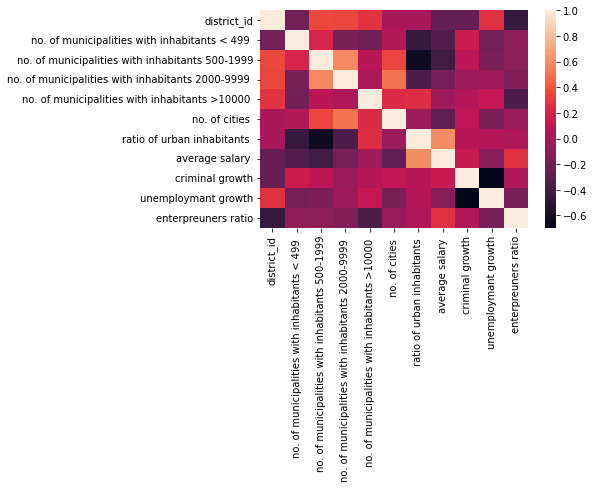

In [203]:
district_df.rename(columns={'code ' : 'district_id'}, inplace=True)
district_df["unemploymant rate '95 "] = pd.to_numeric(district_df["unemploymant rate '95 "], errors='coerce')
#filling NA values with mean
district_df["unemploymant rate '95 "].fillna(district_df["unemploymant rate '95 "].mean(), inplace=True)

district_df["no. of commited crimes '95 "] = pd.to_numeric(district_df["no. of commited crimes '95 "], errors='coerce')
#filling NA values with mean
district_df["no. of commited crimes '95 "].fillna(district_df["no. of commited crimes '95 "].mean(), inplace=True)

#growths
district_df["criminal growth"] = (district_df["no. of commited crimes '96 "] - district_df["no. of commited crimes '95 "]) / district_df["no. of inhabitants"]
district_df['unemploymant growth'] = district_df["unemploymant rate '96 "] - district_df["unemploymant rate '95 "]

#simplifying ratios lmao
district_df['enterpreuners ratio'] = district_df['no. of enterpreneurs per 1000 inhabitants '] / 1000
district_df['ratio of urban inhabitants '] = district_df['ratio of urban inhabitants '] / 100

district_df.drop(columns=['name ', 'no. of enterpreneurs per 1000 inhabitants ', 'no. of inhabitants',
        "unemploymant rate '96 ", "no. of commited crimes '96 ",
        "unemploymant rate '95 ", "no. of commited crimes '95 "], inplace=True)


corr = district_df.corr()
sns.heatmap(corr);
district_df.to_csv('refined/district.csv')

# Merging

In [204]:
refined_df = loan_df.merge(disp_df, on='account_id')
refined_df = refined_df.merge(client_df, on='client_id')
refined_df = refined_df.merge(account_df, on='account_id')
refined_df = refined_df.merge(district_df, left_on='client_district_id', right_on='district_id')
refined_df = refined_df.merge(trans_df, on='account_id')
#refined_df = refined_df.merge(card_df, on='disp_id')
get_age = lambda initial_date, cur_date: cur_date.year - initial_date.year - ((cur_date.month, cur_date.day) < (initial_date.month, initial_date.day))
get_account_age = lambda initial_date,cur_date : (cur_date.year - initial_date.year) * 12 + cur_date.month - initial_date.month
refined_df['age on loan'] = refined_df.apply(lambda row: get_age(row['client_birth_number'], row['loan_date']), axis=1)
refined_df['account age at loan'] = refined_df.apply(lambda row: get_account_age(row['account_date'], row['loan_date']), axis=1)
# refined_df.drop(columns={
#     'account_id', 'disp_id', 'client_id', 'client_district_id', 'district_id_x', 'district_id_y', 'trans_id', 'client_birth_number', 'client_age', 'account_date',
#     'loan_date', 'trans_date', 'no. of municipalities with inhabitants < 499 ', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999 ',
#     'no. of municipalities with inhabitants >10000 ', 'no. of cities '
# })

refined_df = refined_df.drop(columns={
    'account_id', 'disp_id', 'client_id', 'client_district_id', 'district_id_x', 'district_id_y','trans_id', 'client_birth_number', 'client_age', 'account_date',
    'loan_date', 'no. of municipalities with inhabitants < 499 ', 'no. of municipalities with inhabitants 500-1999', 'no. of municipalities with inhabitants 2000-9999 ',
    'no. of municipalities with inhabitants >10000 ', 'no. of cities ', 'trans_date'
})

#refined_df.to_csv('refined/final_data.csv')

In [205]:
refined_df

,loan_id,loan_amount,loan_duration,loan_payments,loan_status,client_gender,account_frequency,region,ratio of urban inhabitants,average salary,criminal growth,unemploymant growth,enterpreuners ratio,trans_type,trans_operation,trans_amount,trans_balance,age on loan,account age at loan
0,5895,93960,60,1566,NaN,0,monthly,east Bohemia,0.535,8390,0.000539,0.61,0.132,credit,credit in cash,800.0,800.0,34,15
1,5895,93960,60,1566,NaN,0,monthly,east Bohemia,0.535,8390,0.000539,0.61,0.132,credit,credit in cash,24425.0,25225.0,34,15
2,5895,93960,60,1566,NaN,0,monthly,east Bohemia,0.535,8390,0.000539,0.61,0.132,credit,credit in cash,500.0,25725.0,34,15
3,5895,93960,60,1566,NaN,0,monthly,east Bohemia,0.535,8390,0.000539,0.61,0.132,credit,interest credited,82.2,25807.2,34,15
4,5895,93960,60,1566,NaN,0,monthly,east Bohemia,0.535,8390,0.000539,0.61,0.132,credit,credit in cash,36637.5,62444.7,34,15
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30195,4967,318480,60,5308,NaN,0,monthly,south Bohemia,0.584,8547,-0.000297,0.99,0.120,withdrawal,withdrawal in cash,-3200.0,32565.8,46,14
30196,4967,318480,60,5308,NaN,0,monthly,south Bohemia,0.584,8547,-0.000297,0.99,0.120,withdrawal,remittance to another bank,-97.0,32468.8,46,14
30197,4967,318480,60,5308,NaN,0,monthly,south Bohemia,0.584,8547,-0.000297,0.99,0.120,withdrawal,remittance to another bank,-2317.0,30151.8,46,14
30198,4967,318480,60,5308,NaN,0,monthly,south Bohemia,0.584,8547,-0.000297,0.99,0.120,withdrawal,remittance to another bank,-2584.0,27567.8,46,14


# Data aggregation

In [206]:
def count_withdrawals(x):
    return sum(x == "withdrawal")
def count_credit(x):
    return sum(x == "credit")
def mean_withdrawals(x):
    return np.mean(x == "withdrawal")
def mean_credit(x):
    return np.mean(x == "credit")
def abs_min(x):
    return x.abs().min()
def rangev(x):
    return x.max() - x.min()


if testing:
    refined_df['loan_status'].fillna('',inplace=True)


non_aggregate_data = refined_df.columns.to_list()
non_aggregate_data.remove('trans_type')
non_aggregate_data.remove('trans_operation')
non_aggregate_data.remove('trans_amount')
non_aggregate_data.remove('trans_balance')

refined_df = refined_df.groupby(non_aggregate_data, as_index=False, group_keys=False).agg({
    'trans_operation' : ['count'],
    'trans_type' : [count_withdrawals, count_credit,mean_withdrawals, mean_credit],
    'trans_amount' : ['mean','min','max','std','last'],
    'trans_balance' : ['mean','min','max','std','last']
})

refined_df.columns = ['%s%s' % (a, '_%s' % b if b else '') for a, b in refined_df.columns]

In [207]:
refined_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354 entries, 0 to 353
Data columns (total 30 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   loan_id                       354 non-null    int64  
 1   loan_amount                   354 non-null    int64  
 2   loan_duration                 354 non-null    int64  
 3   loan_payments                 354 non-null    int64  
 4   loan_status                   354 non-null    object 
 5   client_gender                 354 non-null    int64  
 6   account_frequency             354 non-null    object 
 7   region                        354 non-null    object 
 8   ratio of urban inhabitants    354 non-null    float64
 9   average salary                354 non-null    int64  
 10  criminal growth               354 non-null    float64
 11  unemploymant growth           354 non-null    float64
 12  enterpreuners ratio           354 non-null    float64
 13  age o

# Feature engineering

In [208]:
refined_df['negative_balance'] = 0
refined_df.loc[refined_df['trans_balance_min'] < 0, 'negative_balance'] = 1
refined_df['negative_balance'] = refined_df['negative_balance'].astype(int)

refined_df['months_until_bankrupt'] = np.floor(refined_df['trans_balance_last'] / refined_df['loan_payments'])
refined_df['months_until_bankrupt'] = refined_df['months_until_bankrupt'].astype(int)

refined_df['ops_per_month'] = refined_df['trans_operation_count'] / refined_df['account age at loan']

refined_df.drop(columns=['trans_operation_count','trans_type_count_withdrawals','trans_type_mean_withdrawals'], inplace=True)

refined_df.to_csv('refined/final_data.csv')

# Encoding

In [209]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
refined_df['account_frequency'] = le.fit_transform(refined_df['account_frequency'])
refined_df['region'] = le.fit_transform(refined_df['region'])

# Saving Models

In [210]:
if testing:
    refined_df.to_csv('kaggle/testing_data.csv', index=False)
else:
    refined_df.to_csv('kaggle/training_data.csv', index=False)